In [22]:
# Import necessary libraries
import numpy as np  
import pandas as pd  
from sklearn.impute import SimpleImputer, KNNImputer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
from torch.nn import functional as F
import warnings
warnings.filterwarnings("ignore")

from matplotlib.backends.backend_pdf import PdfPages

from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import StratifiedKFold, train_test_split

In [4]:
class CoxPipeline:
    def __init__(self, alpha=0.5, n_splits=5, random_state=42):
        self.alpha = alpha
        self.n_splits = n_splits
        self.random_state = random_state
        self.model = None
        warnings.filterwarnings("ignore")

    def split_data(self, data, features, target, duration):
        # Train-test split (80% train_val, 20% test)
        train_val_data, test_data = train_test_split(
            data, test_size=0.2, stratify=data[target], random_state=self.random_state
        )
        
        # Further split train_val_data into train and validation (80% of train_val is train and 20% of train_val is val)
        train_data, val_data = train_test_split(
            train_val_data, test_size=0.2, stratify=train_val_data[target], random_state=self.random_state
        )

        # Prepare data for Cox model
        X_train = train_data[features]
        y_train = np.array(list(zip(train_data[target], train_data[duration])), dtype=[(target, bool), (duration, int)])

        X_val = val_data[features]
        y_val = np.array(list(zip(val_data[target], val_data[duration])), dtype=[(target, bool), (duration, int)])

        X_test = test_data[features]
        y_test = np.array(list(zip(test_data[target], test_data[duration])), dtype=[(target, bool), (duration, int)])

        return X_train, y_train, X_val, y_val, X_test, y_test

    def cross_validate(self, X_train, y_train, target,duration):
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        concordance_indices = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train[target])):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            estimator = CoxPHSurvivalAnalysis(alpha=self.alpha)
            estimator.fit(X_train_fold, y_train_fold)

            prediction = estimator.predict(X_val_fold)
            result = concordance_index_censored(y_val_fold[target], y_val_fold[duration], prediction)
            concordance_indices.append(result[0])

            print(f"Fold {fold + 1} Concordance Index: {result[0]}")

        average_concordance_index = np.mean(concordance_indices)
        print("Average Concordance Index:", average_concordance_index)
        return average_concordance_index

    def train_and_evaluate(self, X_train, y_train, X_test, y_test,target,duration):
        self.model = CoxPHSurvivalAnalysis(alpha=self.alpha)
        self.model.fit(X_train, y_train)

        test_predictions = self.model.predict(X_test)
        test_result = concordance_index_censored(y_test[target], y_test[duration], test_predictions)
        print("Test Data Concordance Index:", test_result[0])

        coefficients = pd.Series(self.model.coef_, index=X_test.columns)
        print(coefficients)

        return test_result[0], coefficients
    
    def plot_kaplan_meier(self, data, target, duration):
        time = np.array(list(data[duration].astype(int)))
        events = np.array(list(data[target].astype(bool)))

        survival_probabilities, time_points, conf_int = kaplan_meier_estimator(
            events, time, conf_type="log-log"
        )

        plt.figure(figsize=(10, 6))
        plt.step(time_points, survival_probabilities, where='post', label='Kaplan-Meier Estimate')

        if conf_int.shape[1] == 2 and len(conf_int) == len(time_points):
            plt.fill_between(
                time_points, conf_int[:, 0], conf_int[:, 1], color='grey', alpha=0.2, label='95% Confidence Interval'
            )

        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.title('Kaplan-Meier Survival Estimate')
        plt.legend()
        plt.grid(True)
        plt.show()

    def run_pipeline(self, data, features, target, duration):
        X_train, y_train, X_val, y_val, X_test, y_test = self.split_data(data, features, target, duration)
        self.cross_validate(X_train, y_train, target, duration)

        test_concordance, coefficients = self.train_and_evaluate(X_train, y_train, X_test, y_test,target,duration)
        #self.plot_kaplan_meier(data, target, duration)
        return test_concordance, coefficients


In [5]:
# ----------------------------
# Denoising AutoEncoder model
# ----------------------------
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, noise_level=0.05):  # CHANGED: default noise_level from 0.3 to 0.05
        super().__init__()
        self.noise_level = noise_level
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, training=False):
        if training:
            noise = torch.bernoulli((1 - self.noise_level) * torch.ones_like(x))
            x = x * noise
        return self.decoder(self.encoder(x))

# ----------------------------
# Masked MSE Loss
# ----------------------------
def masked_mse_loss(original, reconstructed, mask):
    diff = (original - reconstructed) ** 2
    masked_diff = diff * mask
    return masked_diff.sum() / mask.sum()

# ----------------------------
# Training the DAE (with val + early stopping)
# ----------------------------
def train_dae(X_np, mask_np, epochs=100, lr=1e-3, hidden_dim=64, noise_level=0.2, patience=10):
    input_dim = X_np.shape[1]
    model = DenoisingAutoEncoder(input_dim, hidden_dim, noise_level)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    original = torch.tensor(X_np, dtype=torch.float32)
    mask = torch.tensor(mask_np, dtype=torch.float32)

    # Mean impute to fill NaNs in inputs
    col_mean = np.nanmean(X_np, axis=0)
    inputs_np = np.where(np.isnan(X_np), col_mean, X_np)
    inputs = torch.tensor(inputs_np, dtype=torch.float32)

    # 90-10 train-val split
    n = inputs.shape[0]
    idx = int(n * 0.9)
    train_inp, val_inp = inputs[:idx], inputs[idx:]
    train_ori, val_ori = original[:idx], original[idx:]
    train_mask, val_mask = mask[:idx], mask[idx:]

    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_inp, training=True)
        loss = masked_mse_loss(train_ori, output, train_mask)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(val_inp, training=False)
            val_loss = masked_mse_loss(val_ori, val_output, val_mask)

        # Track losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} — val loss: {val_loss.item():.4f}")
                break

    # Load best model and return with losses
    model.load_state_dict(best_model)

    # Print final metrics
    #print(f"Final Training Loss: {train_losses[-1]:.4f}")
    #print(f"Best Validation Loss: {min(val_losses):.4f}")

    return model, train_losses, val_losses

# ----------------------------
# Impute numerical using DAE
# ----------------------------
def impute_with_dae(model, X_np, mask_np):
    model.eval()
    with torch.no_grad():
        inputs = torch.nan_to_num(torch.tensor(X_np, dtype=torch.float32), nan=0.0)
        recon = model(inputs, training=False).numpy()
    X_imputed = X_np.copy()
    X_imputed[mask_np] = recon[mask_np]
    return X_imputed

# ----------------------------
# Full pipeline: DAE + Mode
# ----------------------------
def impute_dataframe_with_dae_and_mode(df, num_cols, cat_cols,
                                       epochs=50, lr=1e-3, hidden_dim=64, noise_level=0.2):  # CHANGED default noise_level
    df = df.copy()

    # Step 1: Handle categorical columns — fill with "Missing" temporarily for DAE
    df[cat_cols] = df[cat_cols].fillna("Missing")

    # Step 2: Handle numerical columns — prepare for DAE
    df_num = df[num_cols]
    mask = df_num.isna().values
    # Compute mean and std only on observed entries
    observed = ~mask
    means = np.sum(df_num.fillna(0).values * observed, axis=0) / observed.sum(axis=0)
    stds = np.sqrt(np.sum(((df_num.fillna(0).values - means) * observed) ** 2, axis=0) / observed.sum(axis=0))
    
    # Avoid divide-by-zero
    stds[stds == 0] = 1.0
    
    # Standardize using only valid entries
    df_filled = df_num.fillna(dict(zip(df_num.columns, means)))

    X_scaled = (df_filled.values - means) / stds

    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(df_num.fillna(0))

    # Step 3: Train and impute with DAE
    #dae_model = train_dae(X_scaled, mask, epochs=epochs, lr=lr,
    #                      hidden_dim=hidden_dim, noise_level=noise_level)  # CHANGED

    dae_model, train_losses, val_losses = train_dae(X_scaled, mask, epochs=epochs, lr=lr,
                          hidden_dim=hidden_dim, noise_level=noise_level)

    #X_imputed = impute_with_dae(dae_model, X_scaled, mask)
    X_imputed_scaled = impute_with_dae(dae_model, X_scaled, mask)

    X_imputed = X_imputed_scaled * stds + means
    #X_imputed = scaler.inverse_transform(X_imputed)

    # Step 4: Replace imputed values back
    df[num_cols] = X_imputed

    # Step 5: Impute categorical columns with most frequent (mode)
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    return df


In [25]:

class ImputationPipeline:
    def __init__(self, df, target_columns=[]):
        self.df_original = df.copy()
        self.df = df.copy()
        self.mask_dict = {}
        self.target_columns = target_columns

    def _get_numeric_categorical(self, df):
        df_num = df.select_dtypes(include=[np.number])
        df_cat = df.select_dtypes(exclude=[np.number])
        return df_num, df_cat

    def add_missingness(self, mask_rate=0.1, method='MCAR', seed=42):
        np.random.seed(seed)
        df = self.df.copy()
        self.mask_dict = {}
    
        non_target_cols = [col for col in df.columns if col not in self.target_columns]
        numeric_cols = df[non_target_cols].select_dtypes(include=[np.number]).columns.tolist()
        categorical_cols = df[non_target_cols].select_dtypes(exclude=[np.number]).columns.tolist()
    
        if method == 'MCAR':
            for col in non_target_cols:
                non_missing = df[col].dropna().index
                if len(non_missing) == 0:
                    continue  # skip if all values are already NaN
                n_mask = int(len(non_missing) * mask_rate)
                if n_mask == 0:
                    continue
                mask_idx = np.random.choice(non_missing, n_mask, replace=False)
                df.loc[mask_idx, col] = np.nan
                self.mask_dict[col] = mask_idx
    
        elif method == 'MAR':
            if len(numeric_cols) < 2:
                raise ValueError("Need at least 2 numeric non-target columns for MAR.")
            #condition_col = numeric_cols[0]
            condition_col = 'Nottingham prognostic index'
            threshold = df[condition_col].quantile(0.3)
            for col in numeric_cols[1:]:
                eligible = df[(df[condition_col] > threshold) & (df[col].notna())].index
                #print(f"[DEBUG] {col} | eligible: {len(eligible)} | cond > {threshold}: {(df[condition_col] > threshold).sum()} | col.notna(): {df[col].notna().sum()}")
                if len(eligible) == 0:
                    eligible = df[df[col].notna()].index
                if len(eligible) == 0:
                    continue
                n_mask = int(len(eligible) * mask_rate)
                if n_mask == 0:
                    continue
                mask_idx = np.random.choice(eligible, n_mask, replace=False)
                df.loc[mask_idx, col] = np.nan
                self.mask_dict[col] = mask_idx
    
            for col in categorical_cols:
                eligible = df[(df[condition_col] > threshold) & (df[col].notna())].index
                if len(eligible) == 0:
                    eligible = df[df[col].notna()].index
                if len(eligible) == 0:
                    continue
                n_mask = int(len(eligible) * mask_rate)
                if n_mask == 0:
                    continue
                mask_idx = np.random.choice(eligible, n_mask, replace=False)
                df.loc[mask_idx, col] = np.nan
                self.mask_dict[col] = mask_idx

    
        elif method == 'MNAR':
            for col in numeric_cols:
                threshold = df[col].median()
                eligible = df[(df[col] > threshold) & (df[col].notna())].index
                if len(eligible) == 0:
                    continue
                n_mask = int(len(eligible) * mask_rate)
                if n_mask == 0:
                    continue
                mask_idx = np.random.choice(eligible, n_mask, replace=False)
                df.loc[mask_idx, col] = np.nan
                self.mask_dict[col] = mask_idx
    
            for col in categorical_cols:
                if df[col].dropna().empty:
                    continue
                mode_val = df[col].mode().iloc[0]
                eligible = df[(df[col] == mode_val) & (df[col].notna())].index
                if len(eligible) == 0:
                    continue
                n_mask = int(len(eligible) * mask_rate)
                if n_mask == 0:
                    continue
                mask_idx = np.random.choice(eligible, n_mask, replace=False)
                df.loc[mask_idx, col] = np.nan
                self.mask_dict[col] = mask_idx
    
        else:
            raise ValueError("Unknown missingness type. Choose from 'MCAR', 'MAR', 'MNAR'.")
    
        self.df = df.copy()
        #print(df.isnull().sum())

    def _impute_with_dae(self, epochs=100, lr=1e-3, hidden_dim=64, noise_level=0.3):
        df = self.df.copy()
        df_num, df_cat = self._get_numeric_categorical(df)
    
        num_cols = df_num.columns.tolist()
        cat_cols = df_cat.columns.tolist()
    
        imputed_df = impute_dataframe_with_dae_and_mode(
            df, num_cols, cat_cols,
            epochs=epochs, lr=lr, hidden_dim=hidden_dim, noise_level=noise_level
        )
    
        target_df = self.df_original[self.target_columns]
        return pd.concat([imputed_df[num_cols], imputed_df[cat_cols], target_df], axis=1)


    def impute(self, num_method='mean', cat_method='most_frequent'):
        df_num, df_cat = self._get_numeric_categorical(self.df)

        # Numeric Imputation
        if num_method == 'mean':
            num_imp = SimpleImputer(strategy='mean').fit_transform(df_num)
        elif num_method == 'knn':
            num_imp = KNNImputer(n_neighbors=5).fit_transform(df_num)
        elif num_method == 'mice':
            #num_imp = IterativeImputer(max_iter = 10,random_state=0).fit_transform(df_num)
            #num_imp = IterativeImputer( estimator=HistGradientBoostingRegressor(random_state=0),max_iter=3,random_state=0,skip_complete=True).fit_transform(df_num)
            num_imp = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, max_depth=5, random_state=0), max_iter=3, random_state=0,skip_complete=True).fit_transform(df_num)
        elif num_method == 'dae':
            return self._impute_with_dae()
        else:
            raise ValueError("Unsupported numeric imputation method")

        # Categorical Imputation
        if cat_method == 'most_frequent':
            cat_imp = SimpleImputer(strategy='most_frequent').fit_transform(df_cat)
        elif cat_method == 'missing_token':
            cat_imp = SimpleImputer(strategy='constant', fill_value='missing').fit_transform(df_cat)
        else:
            raise ValueError("Unsupported categorical imputation method")

        df_num_imp = pd.DataFrame(num_imp, columns=df_num.columns, index=df_num.index)
        df_cat_imp = pd.DataFrame(cat_imp, columns=df_cat.columns, index=df_cat.index)
        target_df = self.df_original[self.target_columns]

        return pd.concat([df_num_imp, df_cat_imp, target_df], axis=1)

    def preprocess_for_model(self, df, corr_threshold=0.7):
        df = df.copy()
        df_num, df_cat = self._get_numeric_categorical(df)
    
        # 1. Normalize numeric columns
        scaler = StandardScaler()
        df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns, index=df.index)
    
        # 2. One-hot encode categorical columns
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        cat_encoded = encoder.fit_transform(df_cat)
        cat_cols = encoder.get_feature_names_out(df_cat.columns)
        df_cat_encoded = pd.DataFrame(cat_encoded, columns=cat_cols, index=df.index)
    
        # 3. Combine
        df_combined = pd.concat([df_num_scaled, df_cat_encoded], axis=1)
    
        # 4. Compute correlation matrix and drop correlated columns
        corr_matrix = df_combined.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
        df_final = df_combined.drop(columns=to_drop)
    
        return df_final, to_drop, corr_matrix

    def evaluate(self, imputed_df):
        rmse_list, mae_list = [], []
        norm_rmse_list, norm_mae_list = [], []
        cat_acc_list = []

        df_num, df_cat = self._get_numeric_categorical(imputed_df)

        for col in df_num.columns:
            idx = self.mask_dict.get(col, [])
            if len(idx) == 0:
                continue
            y_true = self.df_original.loc[idx, col]
            y_pred = imputed_df.loc[idx, col]
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            '''
            std = self.df_original[col].std()
            norm_rmse = rmse / std if std != 0 else rmse
            norm_mae = mae / std if std != 0 else mae

            '''
            col_range = self.df_original[col].max() - self.df_original[col].min()
            norm_rmse = rmse / col_range if col_range != 0 else rmse
            norm_mae = mae / col_range if col_range != 0 else mae
            
            rmse_list.append(rmse)
            mae_list.append(mae)
            norm_rmse_list.append(norm_rmse)
            norm_mae_list.append(norm_mae)

        for col in df_cat.columns:
            idx = self.mask_dict.get(col, [])
            if len(idx) == 0:
                continue
            y_true = self.df_original.loc[idx, col]
            y_pred = imputed_df.loc[idx, col]
            acc = accuracy_score(y_true, y_pred)
            cat_acc_list.append(acc)

        return {
            'numeric_method': None,
            'categorical_method': None,
            'mask_rate': None,
            'missingness_type': None,
            'Norm_RMSE': np.mean(norm_rmse_list) if norm_rmse_list else np.nan,
            'Norm_MAE': np.mean(norm_mae_list) if norm_mae_list else np.nan,
            'Cat_Accuracy': np.mean(cat_acc_list) if cat_acc_list else np.nan,
            'RMSE': np.mean(rmse_list) if rmse_list else np.nan,
            'MAE': np.mean(mae_list) if mae_list else np.nan
        }
    '''
    def run(self, mask_rates, numeric_methods, categorical_methods, missingness_type='MCAR', save_path=None):
        all_results = []

        for rate in mask_rates:
            self.add_missingness(mask_rate=rate, method=missingness_type)

            for num_method in numeric_methods:
                for cat_method in categorical_methods:
                    imputed_df = self.impute(num_method=num_method, cat_method=cat_method)
                    metrics = self.evaluate(imputed_df)
                    processed_df, dropped_cols, corr_matrix = self.preprocess_for_model(imputed_df)
                    metrics.update({
                        'numeric_method': num_method,
                        'categorical_method': cat_method,
                        'mask_rate': rate,
                        'missingness_type': missingness_type
                    })

                    all_results.append(metrics)

        result_df = pd.DataFrame(all_results)[[
            'numeric_method', 'categorical_method', 'mask_rate', 'missingness_type',
            'Norm_RMSE', 'Norm_MAE', 'Cat_Accuracy', 'RMSE', 'MAE'
        ]]

        if save_path:
            result_df.to_csv(save_path, index=False)

        return result_df
    '''
    def run(self, mask_rates, numeric_methods, categorical_methods, missingness_type='MCAR', save_path=None):
        all_results = []
        cox_pipe = CoxPipeline(alpha=0.5)
    
        for rate in mask_rates:
            self.add_missingness(mask_rate=rate, method=missingness_type)
    
            for num_method in numeric_methods:
                for cat_method in categorical_methods:
                    imputed_df = self.impute(num_method=num_method, cat_method=cat_method)
                    metrics = self.evaluate(imputed_df)
    
                    # --- Preprocess for Cox model
                    processed_df, dropped_cols, _ = self.preprocess_for_model(imputed_df)
    
                    # --- Prepare columns
                    features = processed_df.columns.tolist()
                    processed_df[self.target_columns] = self.df_original[self.target_columns]
    
                    # --- Run Cox model and get concordance index
                    c_index, _ = cox_pipe.run_pipeline(
                        processed_df,
                        features=features,
                        target=self.target_columns[0],  # e.g., 'OS'
                        duration=self.target_columns[1]  # e.g., 'OS.time'
                    )
    
                    metrics.update({
                        'numeric_method': num_method,
                        'categorical_method': cat_method,
                        'mask_rate': rate,
                        'missingness_type': missingness_type,
                        'c_index': c_index,
                        'final_features': len(features)
                    })
    
                    all_results.append(metrics)
    
        result_df = pd.DataFrame(all_results)[[
            'numeric_method', 'categorical_method', 'mask_rate', 'missingness_type',
            'Norm_RMSE', 'Norm_MAE', 'Cat_Accuracy', 'RMSE', 'MAE', 'c_index', 'final_features'
        ]]
    
        if save_path:
            result_df.to_csv(save_path, index=False)
    
        return result_df
    


In [18]:
df = pd.read_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/data/metabric_before_imp.csv")

In [19]:
df = df.drop(['Unnamed: 0'], axis =1)

In [20]:
def analyze_file(data):
    print("Dataset:")
    display(data)
    
    # Output the shape of the datasetaa
    print("\nShape of the dataset (rows, columns):")
    print(data.shape)
    
    # Output the data types of each column
    print("\nData types of each column:")
    print(data.dtypes)
    
    # Output the count of missing values in each column
    print("\nCount of missing values in each column:")
    print(data.isnull().sum())

analyze_file(df)

Dataset:


,Age at Diagnosis,Type of Breast Surgery,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,...,OS.time,OS,PR Status,Radio Therapy,Relapse Free Status (days),Relapse Free Status,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage
0,27631.1625,MASTECTOMY,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,1.0,Positve,Positive,THREE,...,4276.468750,0,Negative,YES,4276.468750,Not Recurred,ER-/HER2-,0.000000,22.0,2.0
1,15775.1475,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,NO,LumA,1.0,Positve,Positive,THREE,...,2576.027083,0,Positive,YES,2576.027083,Not Recurred,ER+/HER2- High Prolif,2.615035,10.0,1.0
2,17849.7675,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,YES,LumB,1.0,Positve,Positive,TWO,...,4982.618750,1,Positive,NO,4666.068750,Recurred,NaN,2.615035,15.0,2.0
3,17415.1200,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,1.0,Positve,Positive,TWO,...,5020.158333,0,Positive,YES,5020.158333,Not Recurred,NaN,1.307518,25.0,2.0
4,28113.2925,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,1.0,Positve,Positive,THREE,...,1259.097917,1,Positive,YES,572.225000,Recurred,ER+/HER2- High Prolif,2.615035,40.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,15742.2750,BREAST CONSERVING,Breast Invasive Lobular Carcinoma,High,NO,LumA,4.0,Positve,Positive,THREE,...,5992.129167,0,Positive,YES,5992.129167,Not Recurred,ER+/HER2- Low Prolif,5.230071,25.0,NaN
1975,15661.9200,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,NO,LumB,4.0,Positve,Positive,THREE,...,1361.570833,1,Negative,YES,496.131250,Recurred,NaN,7.845106,20.0,NaN
1976,22974.2250,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,NO,LumB,4.0,Positve,Positive,THREE,...,5355.985417,1,Positive,YES,3737.725000,Recurred,NaN,5.230071,25.0,NaN
1977,22338.6900,MASTECTOMY,Breast Invasive Ductal Carcinoma,Moderate,NO,LumB,4.0,Positve,Positive,TWO,...,2624.727083,1,Positive,NO,2624.727083,Not Recurred,ER+/HER2- High Prolif,19.612766,25.0,NaN



Shape of the dataset (rows, columns):
(1979, 31)

Data types of each column:
Age at Diagnosis                  float64
Type of Breast Surgery             object
Cancer Type Detailed               object
Cellularity                        object
Chemotherapy                       object
Pam50 + Claudin-low subtype        object
Cohort                            float64
ER status measured by IHC          object
ER Status                          object
Neoplasm Histologic Grade          object
HER2 status measured by SNP6       object
HER2 Status                        object
Tumor Other Histologic Subtype     object
Hormone Therapy                    object
Inferred Menopausal State          object
Integrative Cluster                object
Primary Tumor Laterality           object
Lymph nodes examined positive     float64
Mutation Count                    float64
Nottingham prognostic index       float64
Oncotree Code                      object
OS.time                           float6

In [28]:
numeric_methods = [ 'dae']
categorical_methods = ['most_frequent', 'missing_token']

# Instantiate pipeline with your DataFrame and optional target columns
pipe = ImputationPipeline(df, target_columns = ['OS', 'OS.time'])

# Run for all missingness types and save results
all_results = []

for missingness_type in ['MCAR', 'MNAR','MAR']:
    result = pipe.run(
        mask_rates=[0.05, 0.1,0.15, 0.2,0.25, 0.3,0.35,0.4,0.45,0.5],
        numeric_methods=numeric_methods,
        categorical_methods=categorical_methods,
        missingness_type=missingness_type,
        #save_path=f"imputation_results_{missingness_type}.csv"
    )
    all_results.append(result)

# Combine all results into a single DataFrame if needed
dae_df = pd.concat(all_results, ignore_index=True)
dae_df.to_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/results/METABRIC_dae_results_CI.csv", index=False)
display(dae_df)

Fold 1 Concordance Index: 0.7641743119266055
Fold 2 Concordance Index: 0.7501698138839832
Fold 3 Concordance Index: 0.7775105504378998
Fold 4 Concordance Index: 0.7557472604336675
Fold 5 Concordance Index: 0.752195705154734
Average Concordance Index: 0.7599595283673779
Test Data Concordance Index: 0.7416177201671853
Age at Diagnosis                                   0.755187
Cohort                                             0.049448
Lymph nodes examined positive                      0.064621
Mutation Count                                     0.033376
Nottingham prognostic index                        0.034458
                                                     ...   
Relapse Free Status_Not Recurred                  -1.503197
3-Gene classifier subtype_ER+/HER2- High Prolif    0.457713
3-Gene classifier subtype_ER+/HER2- Low Prolif     0.274778
3-Gene classifier subtype_ER-/HER2-                0.163687
3-Gene classifier subtype_Missing                  0.391714
Length: 75, dtype: flo

,numeric_method,categorical_method,mask_rate,missingness_type,Norm_RMSE,Norm_MAE,Cat_Accuracy,RMSE,MAE,c_index,final_features
0,dae,most_frequent,0.05,MCAR,0.153221,0.120393,0.0,758.459840,626.921292,0.741618,75
1,dae,missing_token,0.05,MCAR,0.153248,0.120451,0.0,758.669629,627.164691,0.741599,75
2,dae,most_frequent,0.10,MCAR,0.148665,0.117652,0.0,794.380867,649.886689,0.724439,88
3,dae,missing_token,0.10,MCAR,0.148672,0.117654,0.0,794.386927,649.872884,0.724236,88
4,dae,most_frequent,0.15,MCAR,0.148193,0.118903,0.0,809.773707,666.192271,0.708972,93
5,dae,missing_token,0.15,MCAR,0.148237,0.118907,0.0,809.728420,665.995237,0.709157,93
6,dae,most_frequent,0.20,MCAR,0.153764,0.119945,0.0,804.695156,661.393507,0.777172,95
7,dae,missing_token,0.20,MCAR,0.153737,0.119944,0.0,804.498165,661.163838,0.776988,95
8,dae,most_frequent,0.25,MCAR,0.151849,0.118562,0.0,777.678027,651.723604,0.735523,95
9,dae,missing_token,0.25,MCAR,0.151888,0.118598,0.0,777.961838,651.809785,0.734750,95


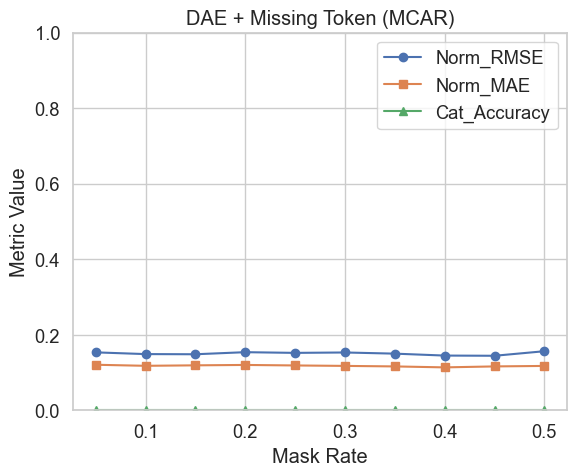

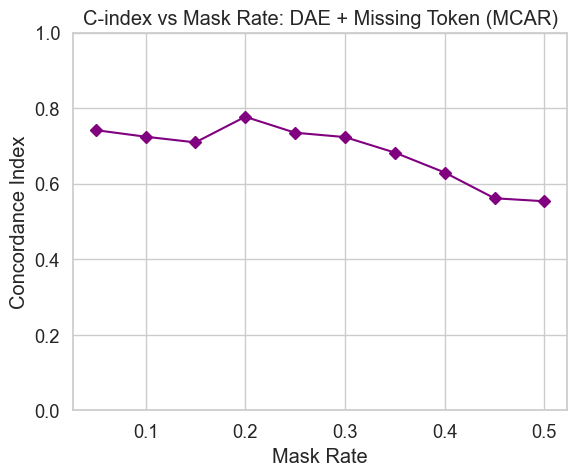

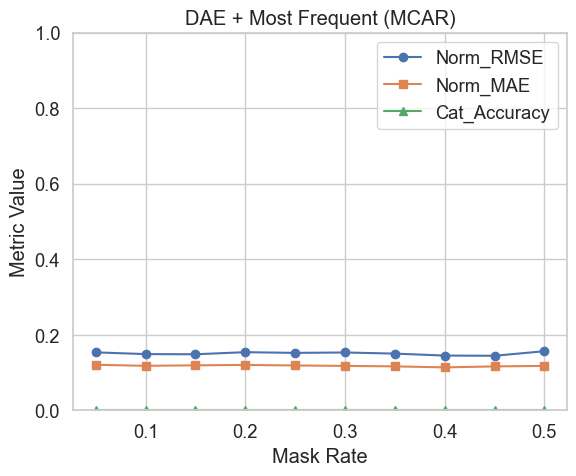

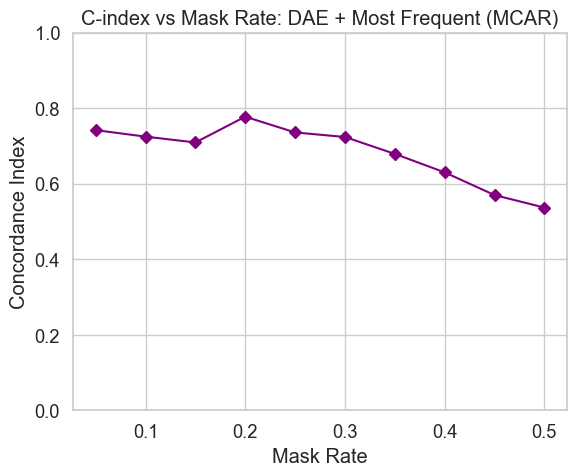

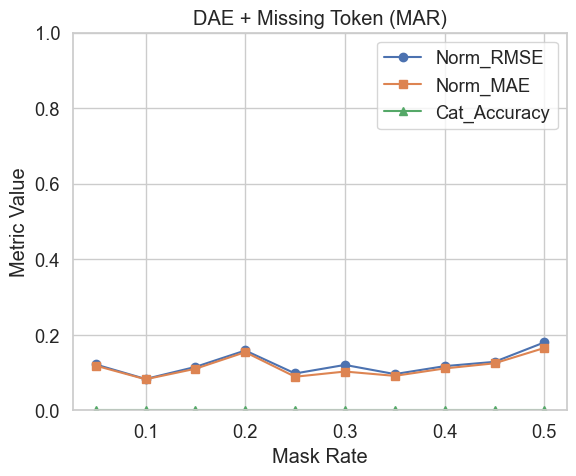

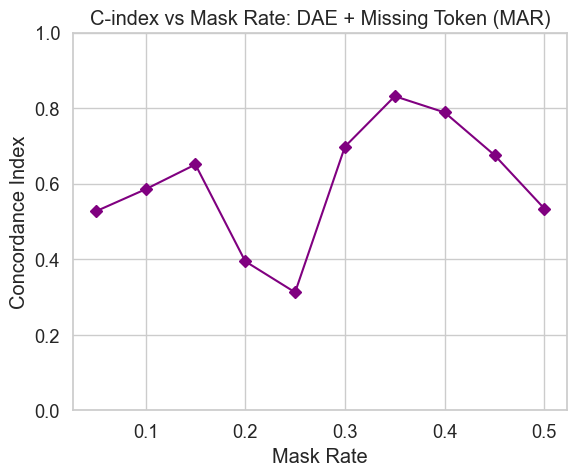

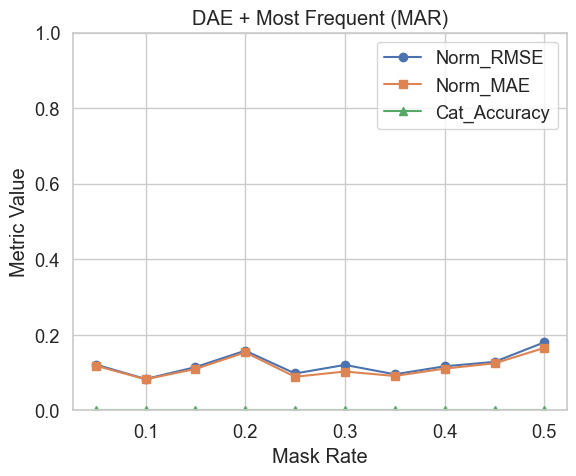

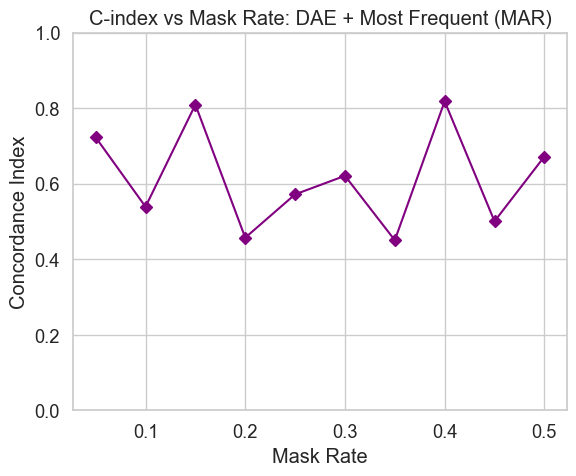

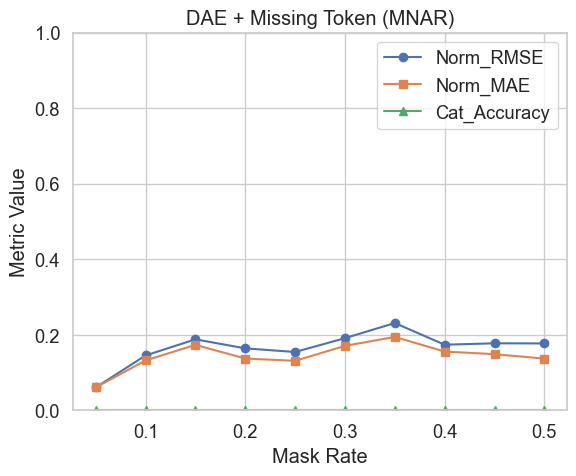

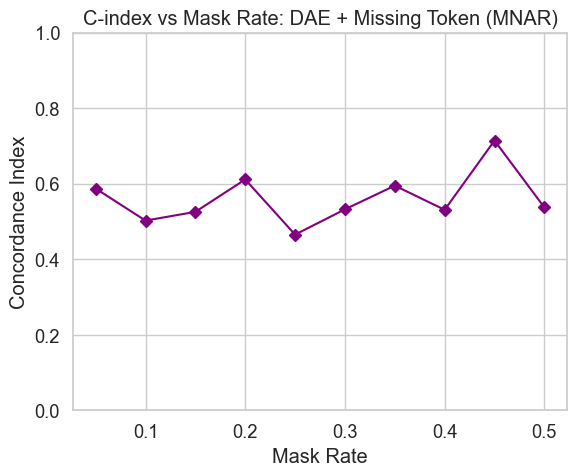

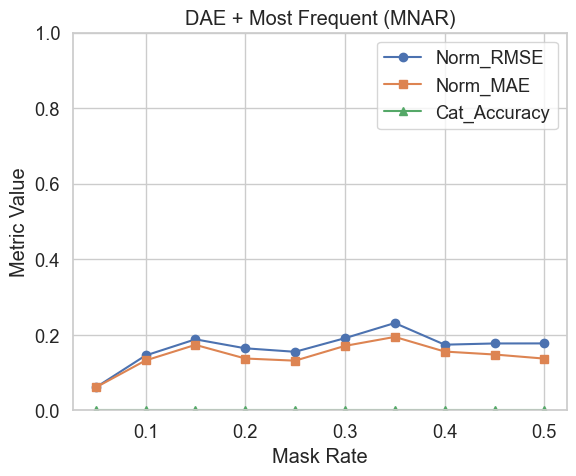

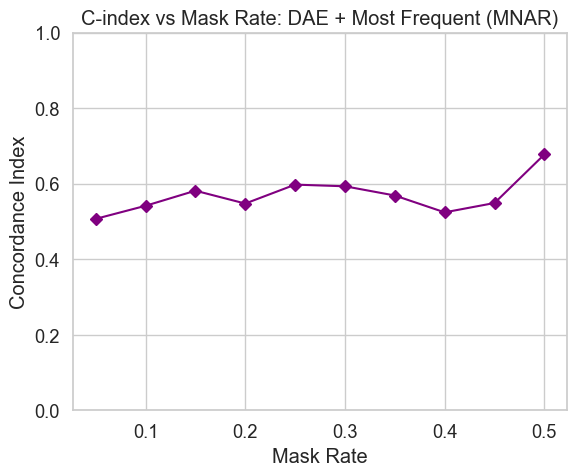

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# Loop through each missingness type
for miss_type in ['MCAR', 'MAR', 'MNAR']:
    df_miss = dae_df[dae_df['missingness_type'] == miss_type]

    # Group by numeric and categorical method
    method_combinations = df_miss.groupby(['numeric_method', 'categorical_method'])

    for (num_method, cat_method), group_df in method_combinations:
        # ---- Plot: RMSE / MAE / Accuracy ----
        plt.figure(figsize=(6, 5))
        plt.plot(group_df['mask_rate'], group_df['Norm_RMSE'], marker='o', label='Norm_RMSE')
        plt.plot(group_df['mask_rate'], group_df['Norm_MAE'], marker='s', label='Norm_MAE')
        plt.plot(group_df['mask_rate'], group_df['Cat_Accuracy'], marker='^', label='Cat_Accuracy')
        title = f"{num_method.upper()} + {cat_method.replace('_', ' ').title()} ({miss_type})"
        plt.title(title)
        plt.xlabel("Mask Rate")
        plt.ylabel("Metric Value")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---- Plot: C-index ----
        if 'c_index' in group_df.columns:
            plt.figure(figsize=(6, 5))
            plt.plot(group_df['mask_rate'], group_df['c_index'], marker='D', color='purple')
            plt.title(f"C-index vs Mask Rate: {title}")
            plt.xlabel("Mask Rate")
            plt.ylabel("Concordance Index")
            plt.ylim(0, 1)
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [30]:
numeric_methods = [ 'mice']
categorical_methods = ['most_frequent', 'missing_token']

# Instantiate pipeline with your DataFrame and optional target columns
pipe = ImputationPipeline(df, target_columns = ['OS', 'OS.time'])

# Run for all missingness types and save results
all_results = []

for missingness_type in [ 'MCAR', 'MAR', 'MNAR']:
    result = pipe.run(
        mask_rates=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5],
        numeric_methods=numeric_methods,
        categorical_methods=categorical_methods,
        missingness_type=missingness_type,
        #save_path=f"imputation_results_{missingness_type}.csv"
    )
    all_results.append(result)

# Combine all results into a single DataFrame if needed
mice_df = pd.concat(all_results, ignore_index=True)
mice_df.to_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/results/METABRIC_mice_results_CI.csv", index=False)
display(mice_df)

Fold 1 Concordance Index: 0.7601376146788991
Fold 2 Concordance Index: 0.7488113028121179
Fold 3 Concordance Index: 0.7657575895085538
Fold 4 Concordance Index: 0.7562135695966425
Fold 5 Concordance Index: 0.7252494596955902
Average Concordance Index: 0.7512339072583607
Test Data Concordance Index: 0.7204065474765701
Age at Diagnosis                                                  0.724053
Cohort                                                            0.055885
Lymph nodes examined positive                                     0.066262
Mutation Count                                                    0.028705
Nottingham prognostic index                                       0.071506
Tumor Size                                                        0.042076
Tumor Stage                                                       0.179442
Type of Breast Surgery_BREAST CONSERVING                          0.006818
Cancer Type Detailed_Breast                                      -0.256786
Cancer

,numeric_method,categorical_method,mask_rate,missingness_type,Norm_RMSE,Norm_MAE,Cat_Accuracy,RMSE,MAE,c_index,final_features
0,mice,most_frequent,0.10,MCAR,0.105905,0.077271,0.631877,589.304240,451.593434,0.720407,54
1,mice,missing_token,0.10,MCAR,0.105905,0.077271,0.000000,589.304240,451.593434,0.721916,80
2,mice,most_frequent,0.15,MCAR,0.114098,0.080032,0.612614,608.470459,460.479178,0.702344,59
3,mice,missing_token,0.15,MCAR,0.114098,0.080032,0.000000,608.470459,460.479178,0.698790,93
4,mice,most_frequent,0.20,MCAR,0.115586,0.083468,0.614131,613.813135,470.191530,0.684208,67
5,mice,missing_token,0.20,MCAR,0.115586,0.083468,0.000000,613.813135,470.191530,0.697722,92
6,mice,most_frequent,0.25,MCAR,0.127341,0.090435,0.607783,634.012778,488.643632,0.713815,67
7,mice,missing_token,0.25,MCAR,0.127341,0.090435,0.000000,634.012778,488.643632,0.713483,92
8,mice,most_frequent,0.30,MCAR,0.131382,0.093012,0.622775,618.727043,481.733104,0.710998,65
9,mice,missing_token,0.30,MCAR,0.131382,0.093012,0.000000,618.727043,481.733104,0.714607,88


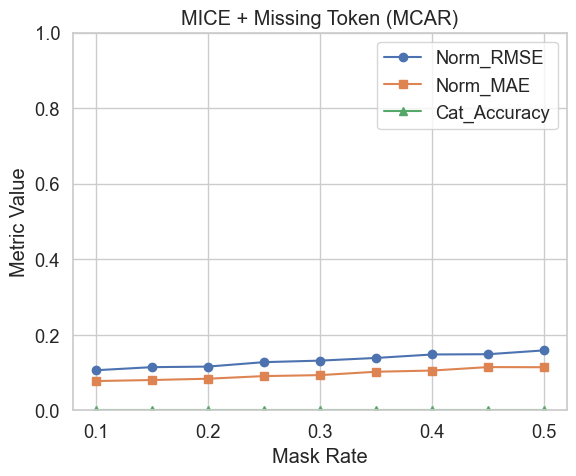

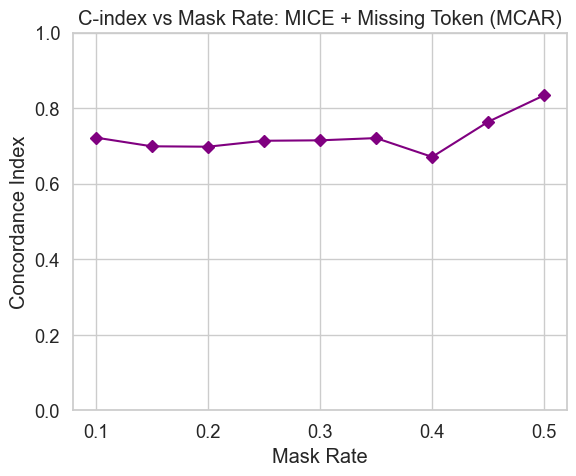

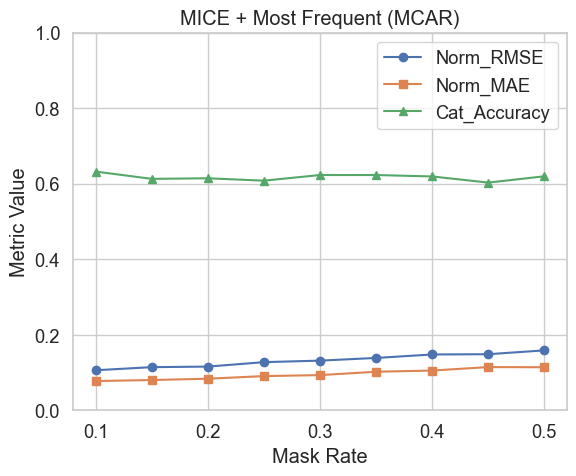

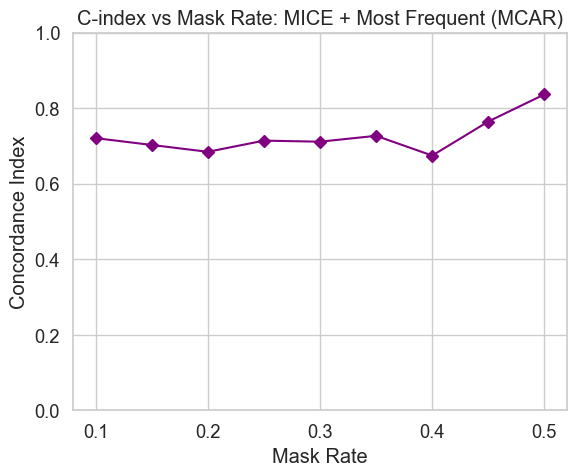

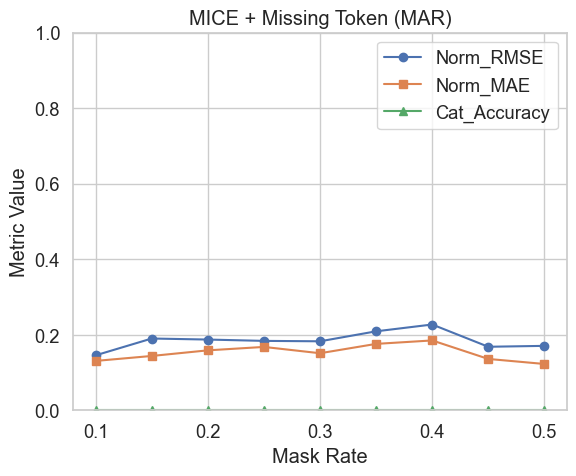

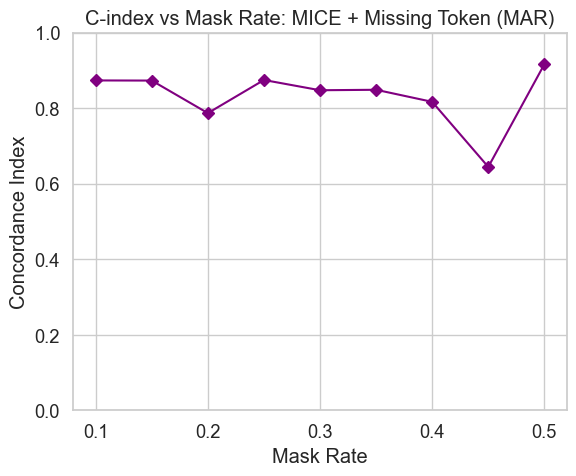

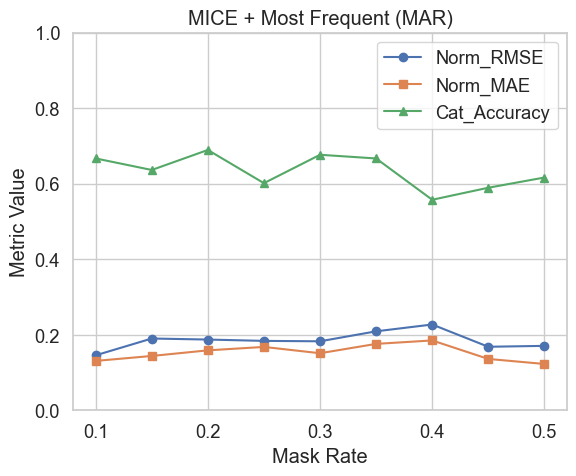

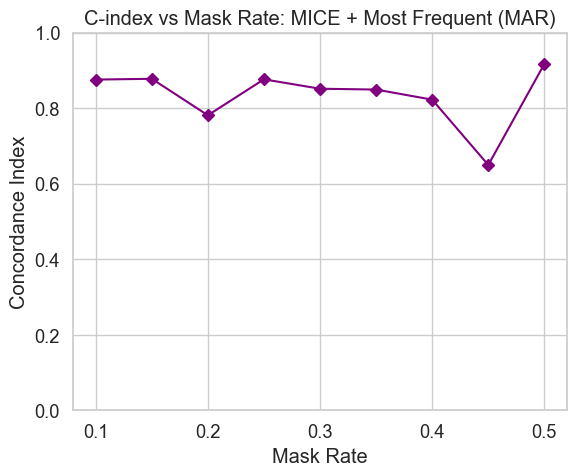

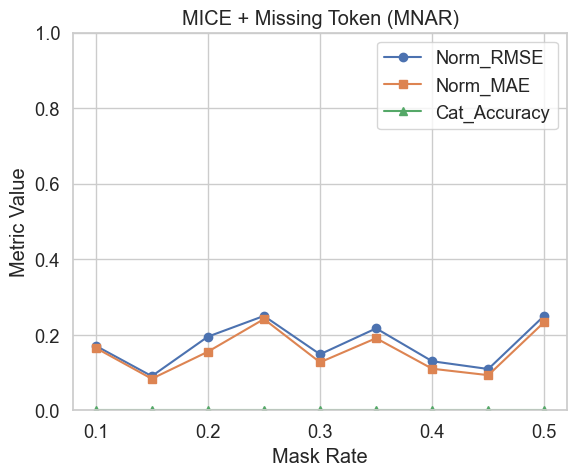

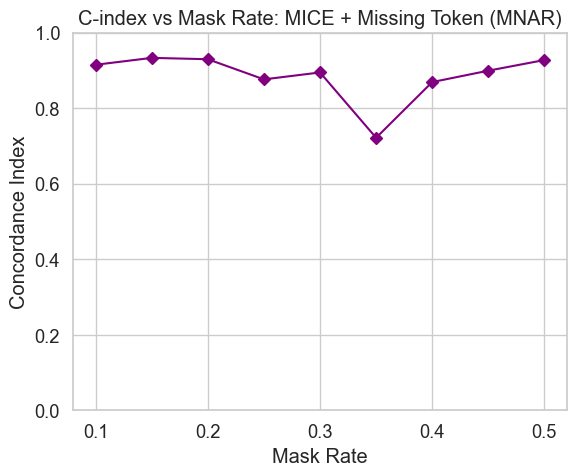

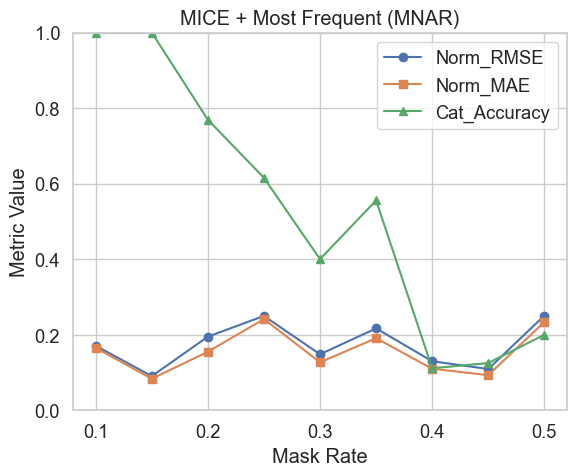

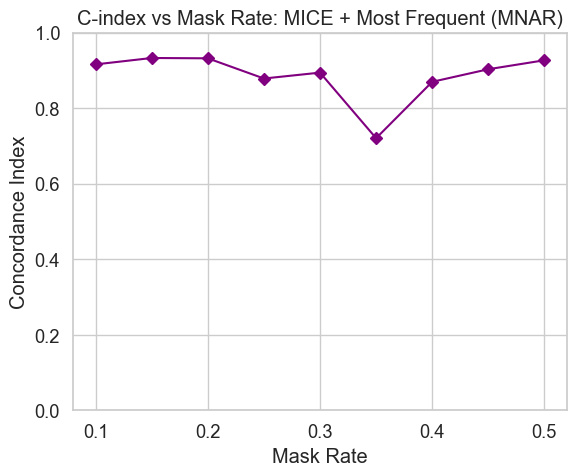

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# Loop through each missingness type
for miss_type in ['MCAR', 'MAR', 'MNAR']:
    df_miss = mice_df[mice_df['missingness_type'] == miss_type]

    # Group by numeric and categorical method
    method_combinations = df_miss.groupby(['numeric_method', 'categorical_method'])

    for (num_method, cat_method), group_df in method_combinations:
        # ---- Plot: RMSE / MAE / Accuracy ----
        plt.figure(figsize=(6, 5))
        plt.plot(group_df['mask_rate'], group_df['Norm_RMSE'], marker='o', label='Norm_RMSE')
        plt.plot(group_df['mask_rate'], group_df['Norm_MAE'], marker='s', label='Norm_MAE')
        plt.plot(group_df['mask_rate'], group_df['Cat_Accuracy'], marker='^', label='Cat_Accuracy')
        title = f"{num_method.upper()} + {cat_method.replace('_', ' ').title()} ({miss_type})"
        plt.title(title)
        plt.xlabel("Mask Rate")
        plt.ylabel("Metric Value")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---- Plot: C-index ----
        if 'c_index' in group_df.columns:
            plt.figure(figsize=(6, 5))
            plt.plot(group_df['mask_rate'], group_df['c_index'], marker='D', color='purple')
            plt.title(f"C-index vs Mask Rate: {title}")
            plt.xlabel("Mask Rate")
            plt.ylabel("Concordance Index")
            plt.ylim(0, 1)
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [32]:
numeric_methods = [ 'knn']
categorical_methods = ['most_frequent', 'missing_token']

# Instantiate pipeline with your DataFrame and optional target columns
pipe = ImputationPipeline(df, target_columns = ['OS', 'OS.time'])

# Run for all missingness types and save results
all_results = []

for missingness_type in [ 'MCAR', 'MAR', 'MNAR']:
    result = pipe.run(
        mask_rates=[0.05, 0.1,0.15, 0.2,0.25, 0.3,0.35,0.4,0.45,0.5],
        numeric_methods=numeric_methods,
        categorical_methods=categorical_methods,
        missingness_type=missingness_type,
        #save_path=f"imputation_results_{missingness_type}.csv"
    )
    all_results.append(result)

# Combine all results into a single DataFrame if needed
kNN_df = pd.concat(all_results, ignore_index=True)
kNN_df.to_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/results/METABRIC_kNN_results_CI.csv", index=False)
display(kNN_df)

Fold 1 Concordance Index: 0.7794036697247706
Fold 2 Concordance Index: 0.7536566589684373
Fold 3 Concordance Index: 0.7775559286654263
Fold 4 Concordance Index: 0.755420844019585
Fold 5 Concordance Index: 0.7551846231664138
Average Concordance Index: 0.7642443449089267
Test Data Concordance Index: 0.7389479111045645
Age at Diagnosis                                                  0.625004
Cohort                                                            0.070478
Lymph nodes examined positive                                     0.065386
Mutation Count                                                    0.039565
Nottingham prognostic index                                       0.019058
Tumor Size                                                        0.039541
Tumor Stage                                                       0.288643
Type of Breast Surgery_BREAST CONSERVING                         -0.027872
Cancer Type Detailed_Breast                                      -0.198902
Cancer 

,numeric_method,categorical_method,mask_rate,missingness_type,Norm_RMSE,Norm_MAE,Cat_Accuracy,RMSE,MAE,c_index,final_features
0,knn,most_frequent,0.05,MCAR,0.144612,0.108396,0.644480,648.510624,486.096607,0.738948,53
1,knn,missing_token,0.05,MCAR,0.144612,0.108396,0.000000,648.510624,486.096607,0.745448,75
2,knn,most_frequent,0.10,MCAR,0.141957,0.107354,0.606316,710.320983,531.841062,0.725949,59
3,knn,missing_token,0.10,MCAR,0.141957,0.107354,0.000000,710.320983,531.841062,0.729668,88
4,knn,most_frequent,0.15,MCAR,0.146745,0.112314,0.619630,728.717460,540.120448,0.730736,65
5,knn,missing_token,0.15,MCAR,0.146745,0.112314,0.000000,728.717460,540.120448,0.731472,94
6,knn,most_frequent,0.20,MCAR,0.144706,0.107629,0.618002,697.867120,545.818763,0.742409,69
7,knn,missing_token,0.20,MCAR,0.144706,0.107629,0.000000,697.867120,545.818763,0.742207,94
8,knn,most_frequent,0.25,MCAR,0.145624,0.107997,0.612305,675.794150,513.845338,0.748780,67
9,knn,missing_token,0.25,MCAR,0.145624,0.107997,0.000000,675.794150,513.845338,0.748835,94


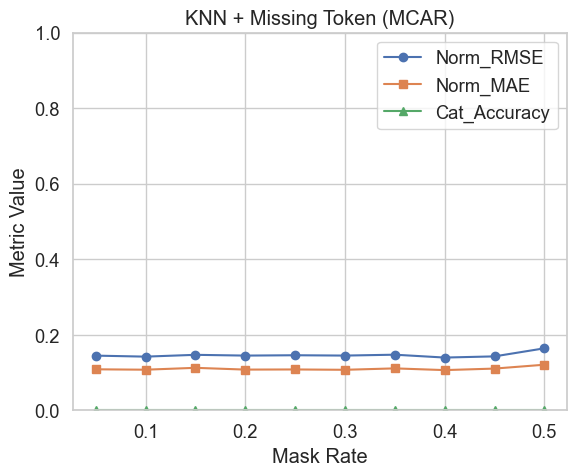

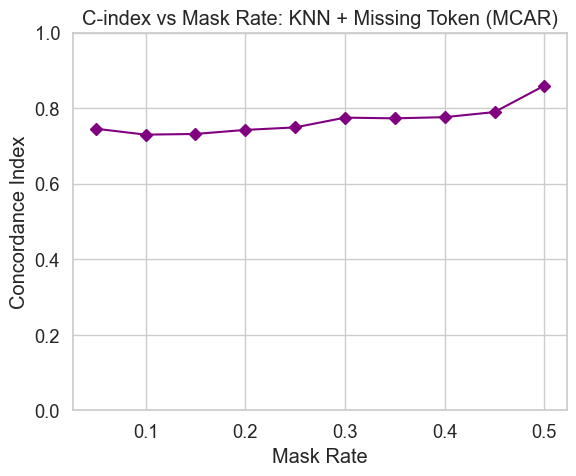

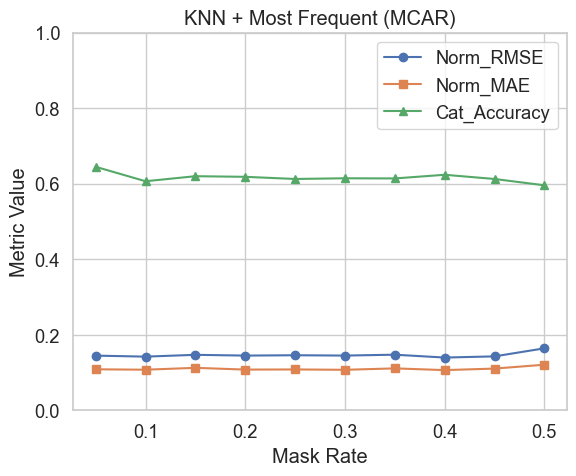

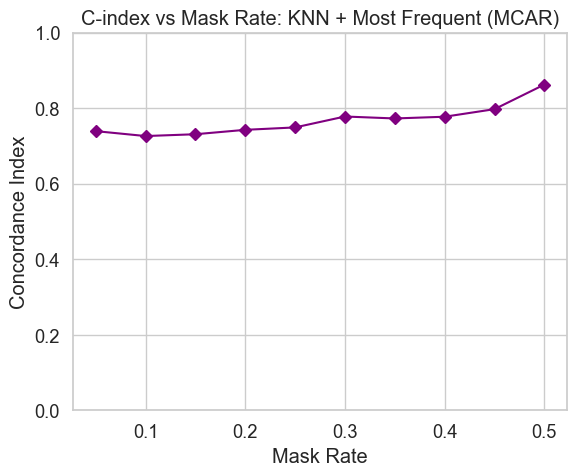

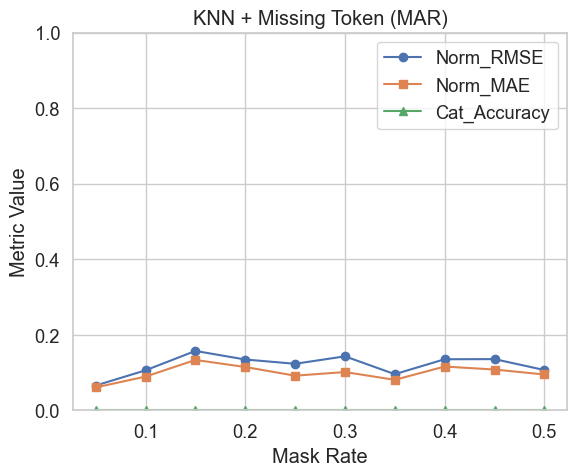

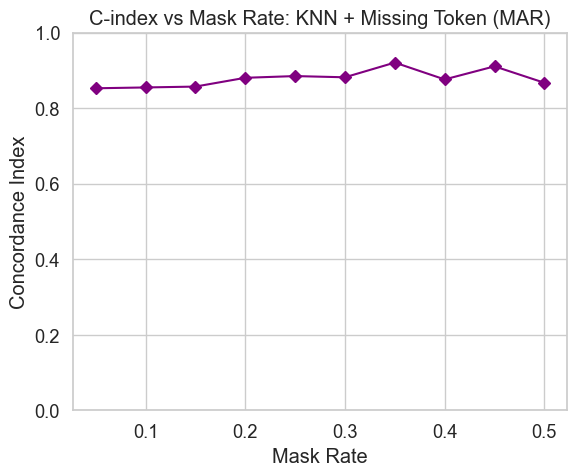

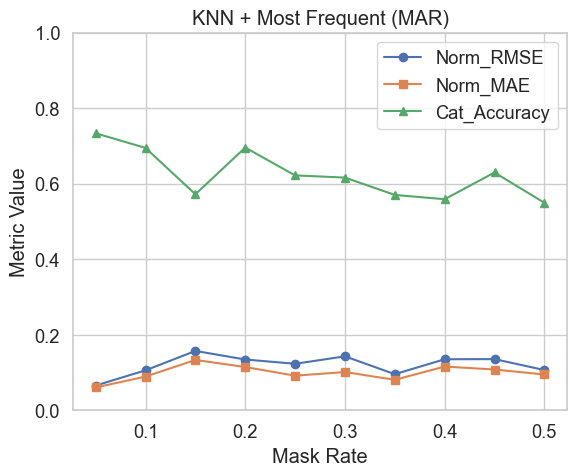

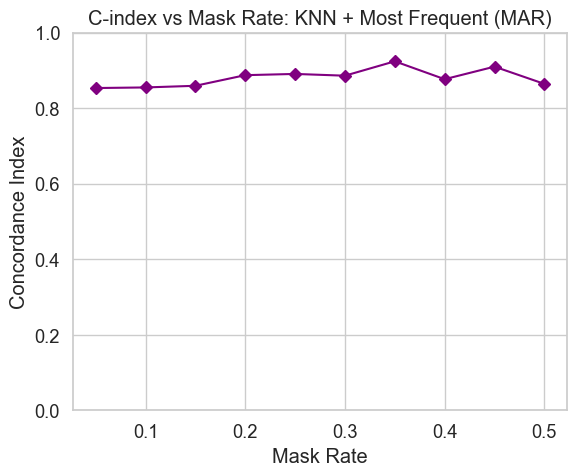

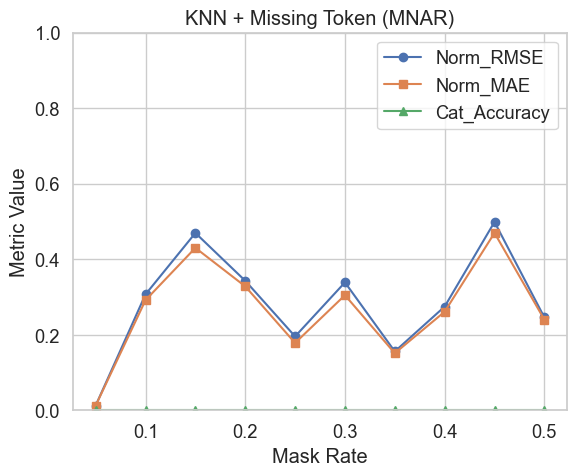

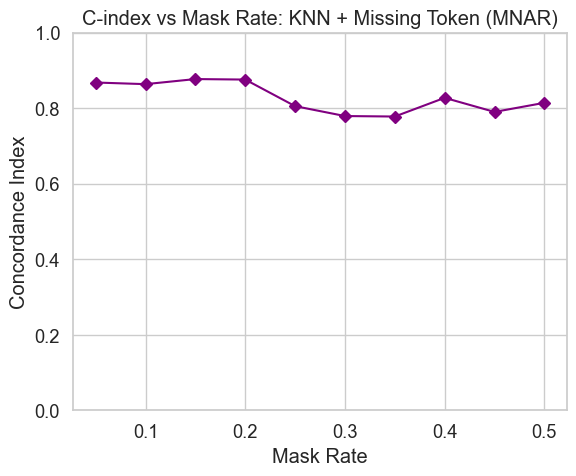

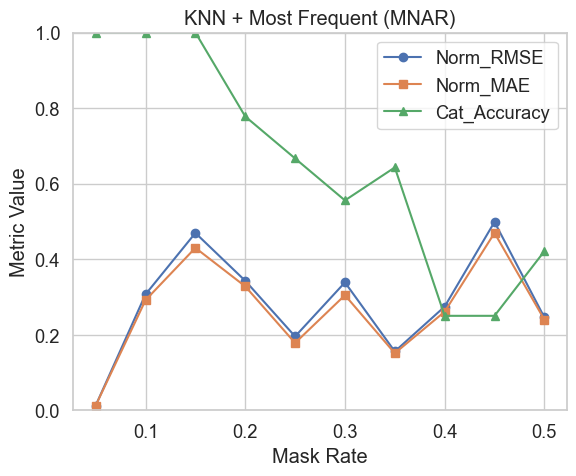

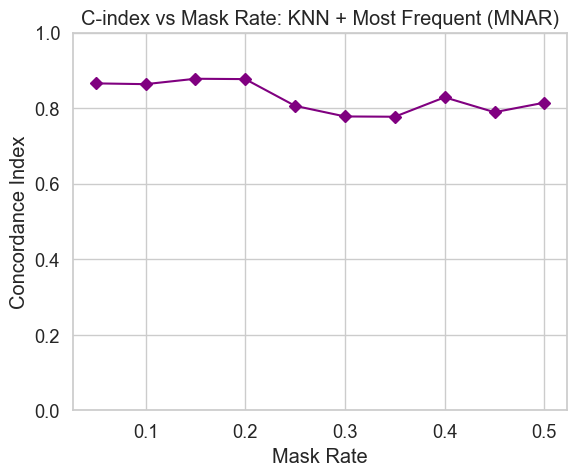

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# Loop through each missingness type
for miss_type in ['MCAR', 'MAR', 'MNAR']:
    df_miss = kNN_df[kNN_df['missingness_type'] == miss_type]

    # Group by numeric and categorical method
    method_combinations = df_miss.groupby(['numeric_method', 'categorical_method'])

    for (num_method, cat_method), group_df in method_combinations:
        # ---- Plot: RMSE / MAE / Accuracy ----
        plt.figure(figsize=(6, 5))
        plt.plot(group_df['mask_rate'], group_df['Norm_RMSE'], marker='o', label='Norm_RMSE')
        plt.plot(group_df['mask_rate'], group_df['Norm_MAE'], marker='s', label='Norm_MAE')
        plt.plot(group_df['mask_rate'], group_df['Cat_Accuracy'], marker='^', label='Cat_Accuracy')
        title = f"{num_method.upper()} + {cat_method.replace('_', ' ').title()} ({miss_type})"
        plt.title(title)
        plt.xlabel("Mask Rate")
        plt.ylabel("Metric Value")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---- Plot: C-index ----
        if 'c_index' in group_df.columns:
            plt.figure(figsize=(6, 5))
            plt.plot(group_df['mask_rate'], group_df['c_index'], marker='D', color='purple')
            plt.title(f"C-index vs Mask Rate: {title}")
            plt.xlabel("Mask Rate")
            plt.ylabel("Concordance Index")
            plt.ylim(0, 1)
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [35]:
numeric_methods = ['mean']
categorical_methods = ['most_frequent', 'missing_token']

# Instantiate pipeline with your DataFrame and optional target columns
pipe = ImputationPipeline(df, target_columns = ['OS', 'OS.time'])

# Run for all missingness types and save results
all_results = []

for missingness_type in ['MCAR', 'MAR', 'MNAR']:
    result = pipe.run(
        mask_rates=[0.05, 0.1,0.15, 0.2,0.25, 0.3,0.35,0.4,0.45,0.5],
        numeric_methods=numeric_methods,
        categorical_methods=categorical_methods,
        missingness_type=missingness_type,
        #save_path=f"imputation_results_{missingness_type}.csv"
    )
    all_results.append(result)

# Combine all results into a single DataFrame if needed
mean_df = pd.concat(all_results, ignore_index=True)
mean_df.to_csv("/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/results/METABRIC_mean_results_CI.csv", index=False)
display(mean_df)

Fold 1 Concordance Index: 0.7688990825688073
Fold 2 Concordance Index: 0.7515736086582439
Fold 3 Concordance Index: 0.7750601261514726
Fold 4 Concordance Index: 0.7486127302401492
Fold 5 Concordance Index: 0.751873821676553
Average Concordance Index: 0.7592038738590452
Test Data Concordance Index: 0.734123842315553
Age at Diagnosis                                                  0.654390
Cohort                                                            0.056745
Lymph nodes examined positive                                     0.055022
Mutation Count                                                    0.035290
Nottingham prognostic index                                       0.048175
Tumor Size                                                        0.038377
Tumor Stage                                                       0.184118
Type of Breast Surgery_BREAST CONSERVING                         -0.043916
Cancer Type Detailed_Breast                                      -0.131530
Cancer T

,numeric_method,categorical_method,mask_rate,missingness_type,Norm_RMSE,Norm_MAE,Cat_Accuracy,RMSE,MAE,c_index,final_features
0,mean,most_frequent,0.05,MCAR,0.153245,0.120405,0.644480,758.651650,627.222335,0.734124,53
1,mean,missing_token,0.05,MCAR,0.153245,0.120405,0.000000,758.651650,627.222335,0.741581,75
2,mean,most_frequent,0.10,MCAR,0.148668,0.117625,0.606316,794.581494,649.957368,0.719983,59
3,mean,missing_token,0.10,MCAR,0.148668,0.117625,0.000000,794.581494,649.957368,0.724310,88
4,mean,most_frequent,0.15,MCAR,0.148226,0.118898,0.619630,809.604220,665.908685,0.703909,64
5,mean,missing_token,0.15,MCAR,0.148226,0.118898,0.000000,809.604220,665.908685,0.709009,93
6,mean,most_frequent,0.20,MCAR,0.153760,0.119952,0.618002,804.540868,661.188889,0.779952,70
7,mean,missing_token,0.20,MCAR,0.153760,0.119952,0.000000,804.540868,661.188889,0.777117,95
8,mean,most_frequent,0.25,MCAR,0.151897,0.118608,0.612305,778.127290,651.940423,0.730883,68
9,mean,missing_token,0.25,MCAR,0.151897,0.118608,0.000000,778.127290,651.940423,0.734989,95


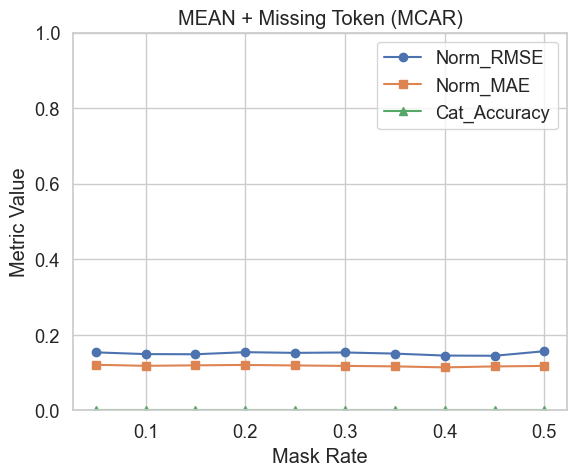

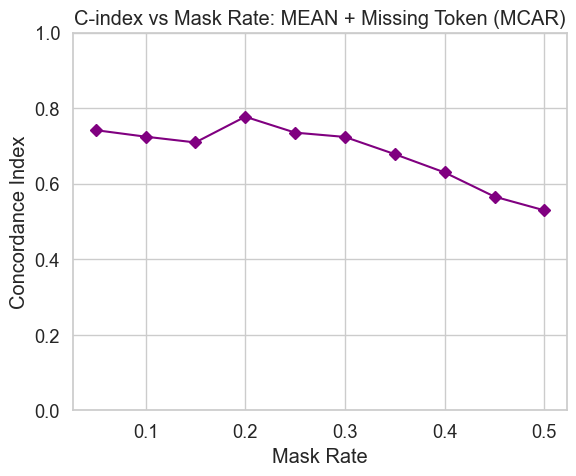

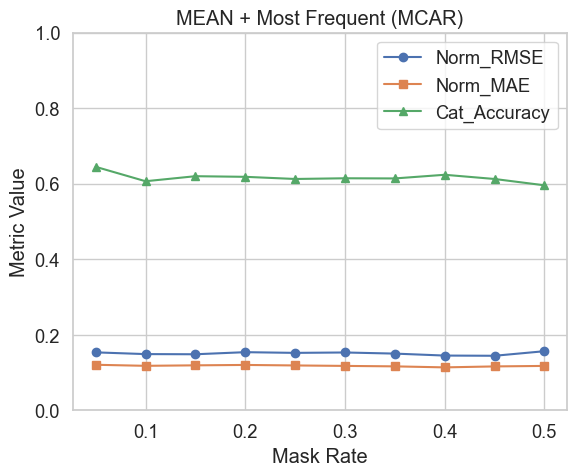

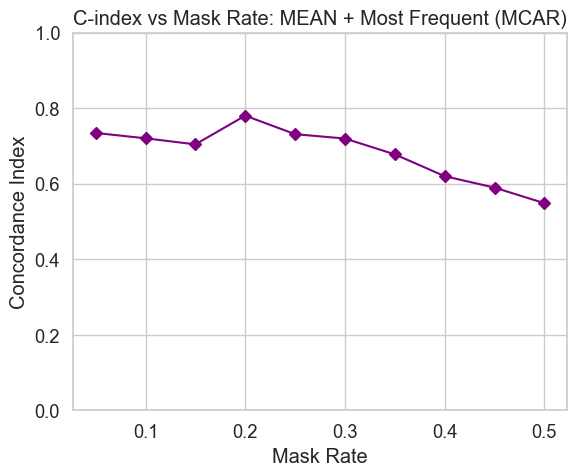

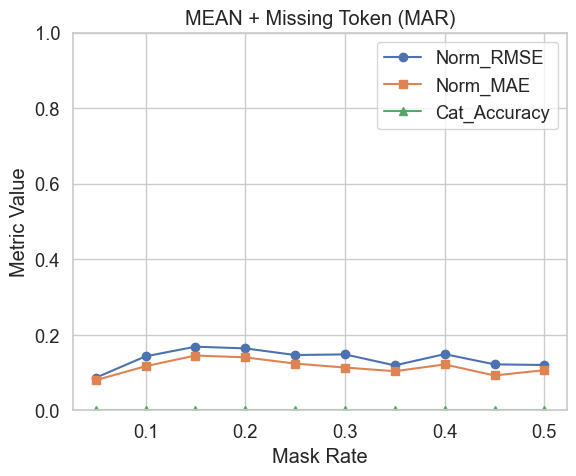

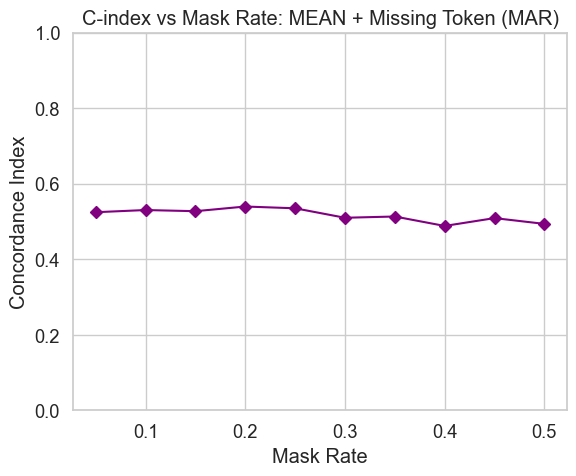

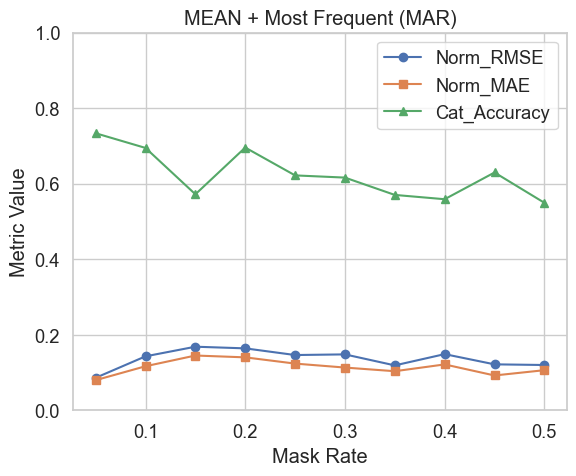

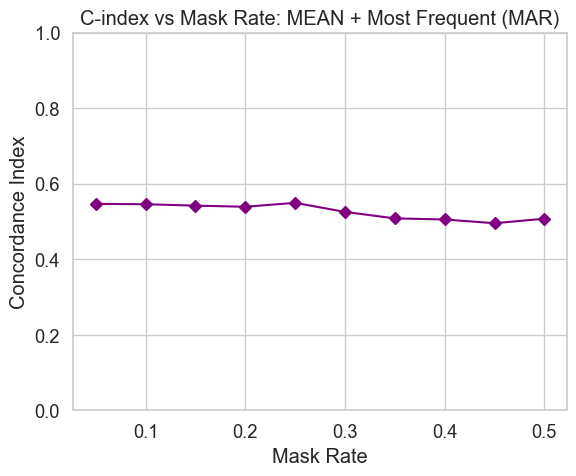

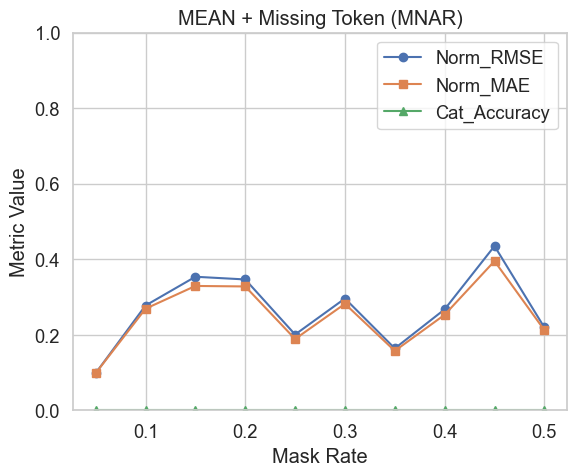

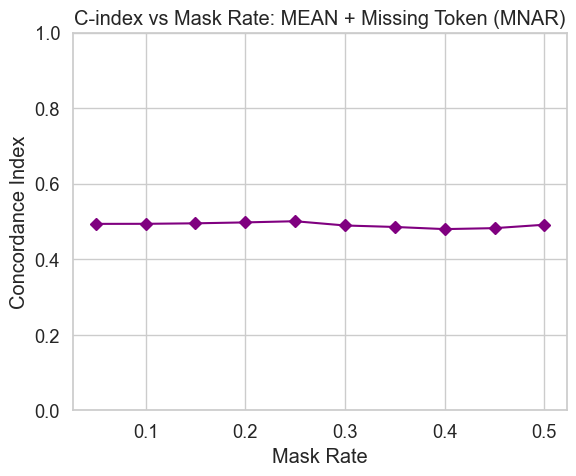

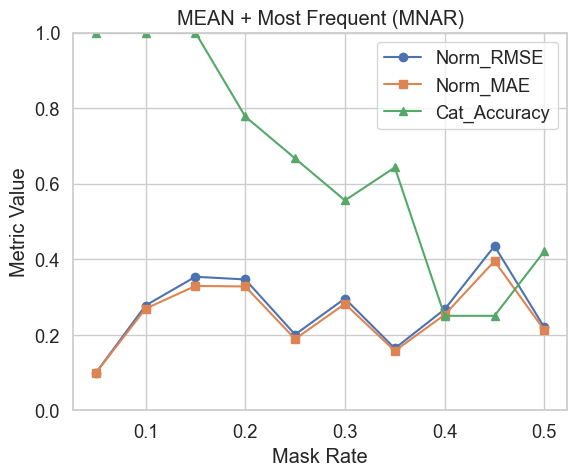

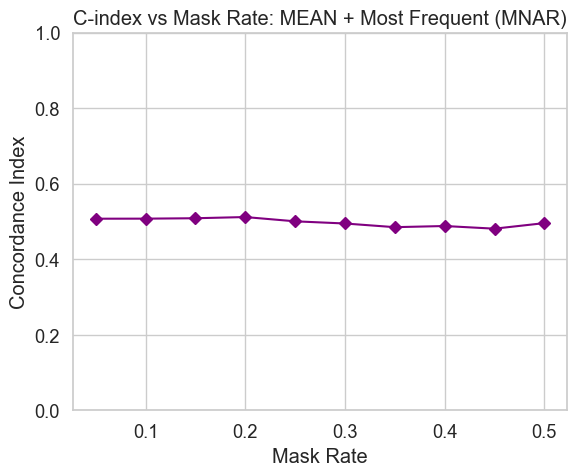

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# Loop through each missingness type
for miss_type in ['MCAR', 'MAR', 'MNAR']:
    df_miss = mean_df[mean_df['missingness_type'] == miss_type]

    # Group by numeric and categorical method
    method_combinations = df_miss.groupby(['numeric_method', 'categorical_method'])

    for (num_method, cat_method), group_df in method_combinations:
        # ---- Plot: RMSE / MAE / Accuracy ----
        plt.figure(figsize=(6, 5))
        plt.plot(group_df['mask_rate'], group_df['Norm_RMSE'], marker='o', label='Norm_RMSE')
        plt.plot(group_df['mask_rate'], group_df['Norm_MAE'], marker='s', label='Norm_MAE')
        plt.plot(group_df['mask_rate'], group_df['Cat_Accuracy'], marker='^', label='Cat_Accuracy')
        title = f"{num_method.upper()} + {cat_method.replace('_', ' ').title()} ({miss_type})"
        plt.title(title)
        plt.xlabel("Mask Rate")
        plt.ylabel("Metric Value")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # ---- Plot: C-index ----
        if 'c_index' in group_df.columns:
            plt.figure(figsize=(6, 5))
            plt.plot(group_df['mask_rate'], group_df['c_index'], marker='D', color='purple')
            plt.title(f"C-index vs Mask Rate: {title}")
            plt.xlabel("Mask Rate")
            plt.ylabel("Concordance Index")
            plt.ylim(0, 1)
            plt.grid(True)
            plt.tight_layout()
            plt.show()


In [39]:
def plot_all_metrics_comparison(
    df,
    output_path='/Users/simrantanwar/Desktop/College/DDP_phase2/New Experiments/results/metabric_added_missingness_CI.pdf',
    metrics=['Norm_RMSE', 'Norm_MAE', 'Cat_Accuracy', 'c_index']
):
    # Filter to use only 'most_frequent' for categorical
    df = df[df['categorical_method'] == 'most_frequent'].copy()
    df['method'] = df['numeric_method'] + '+' + df['categorical_method']

    sns.set(style="whitegrid", font_scale=1.2)
    with PdfPages(output_path) as pdf:
        for metric in metrics:
            for miss_type in df['missingness_type'].unique():
                subset = df[df['missingness_type'] == miss_type]
                
                plt.figure(figsize=(10, 6))
                sns.lineplot(
                    data=subset,
                    x='mask_rate',
                    y=metric,
                    hue='method',
                    marker='o'
                )
                plt.title(f"{metric} vs Mask Rate ({miss_type})")
                plt.xlabel("Mask Rate")
                plt.ylabel(metric if metric != 'c_index' else 'Concordance Index')
                plt.ylim(0, 1)
                plt.legend(title="Imputation Method", bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.tight_layout()
                pdf.savefig()
                plt.close()

In [40]:
combined_df = pd.concat([mice_df, dae_df, kNN_df, mean_df], ignore_index=True)
plot_all_metrics_comparison(combined_df)
